In [1]:
# Import necessary libraries
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
from huggingface_hub import InferenceClient
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from IPython.display import display, HTML
from torchvision import transforms 
import cv2

# Import utility functions from util.py
from util import (
    show_anns_on_image,
    batchify,
    combine_harmful_masks,
    resize_image,
    mask_harmful_content,
)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Global variables for models
# Load SAM model
model_type = "vit_h"  # Options: 'vit_h', 'vit_l', 'vit_b'
sam_checkpoint = "sam_vit_h_4b8939.pth"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Load CLIP model
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

/ext3/miniconda3/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)
/ext3/miniconda3/li

In [4]:
def generate_image(prompt):
    """
    Generates an image using Stable Diffusion.

    Args:
        prompt (str): Text prompt for image generation.

    Returns:
        PIL.Image.Image: Generated image.
    """
    # Using Inference API
    client = InferenceClient(
        model="stabilityai/stable-diffusion-3-medium-diffusers",
        token=""  # Replace with your Hugging Face token
    )
    
    image = client.text_to_image(prompt)
    return image

def segment_image(image):
    """
    Segments the image using SAM (Segment Anything Model).

    Args:
        image (PIL.Image.Image): Image to segment.

    Returns:
        list: List of segmentation masks.
    """
    # Convert PIL image to NumPy array
    image_np = np.array(image)
    image_np = cv2.resize(image_np, (1024, 1024), interpolation=cv2.INTER_AREA)
    
    mask_generator = SamAutomaticMaskGenerator(
        sam,
        points_per_side=32,           # Adjust for finer or coarser grid, 64
        min_mask_region_area=50,      # Set minimum area for masks
        box_nms_thresh=0.2,           # Adjust NMS threshold
        stability_score_thresh=0.2,   # Set stability score threshold
    )

    mask_generator.predictor.model.to(device)

    # image_tensor = torch.tensor(image_np).to(device)
    masks = mask_generator.generate(image_np)

    print(f"Generated {len(masks)} masks.")
    return masks

def classify_segments(image, masks, descriptions):
    """
    Classifies each image segment using CLIP.

    Args:
        image (PIL.Image.Image): Original image.
        masks (list): List of segmentation masks.
        descriptions (list): List of descriptions for classification.

    Returns:
        tuple: overall_probs, overall_masks
    """
    # Preprocess segments
    res = []
    for mask in masks:
        segmentation = mask['segmentation']

        # Mask out all other parts
        segment_image = np.array(image).copy()
        mask_bool = segmentation.astype(bool)
        segment_image[~mask_bool] = 255  # Set the background to white

        # Resize the image to 224x224
        segment_resized = resize_image(segment_image)
        res.append(segment_resized)

    # Define batch size
    batch_size = 16

    # Split images into batches
    image_batches = batchify(res, batch_size)

    # Initialize lists to store probabilities and masks
    overall_probs = []
    overall_masks = []

    # Process each batch
    for batch_idx, image_batch in enumerate(image_batches):
        # Process inputs in a batch
        inputs = clip_processor(
            text=descriptions,
            images=image_batch,
            padding="max_length",
            return_tensors="pt"
        )
        
        # Move inputs to the appropriate device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Perform inference in a batch
        with torch.no_grad():
            outputs = clip_model(**inputs)
        
        # Extract logits and compute probabilities
        logits_per_image = outputs.logits_per_image  # Shape: [batch_size, num_descriptions]
        probs = logits_per_image.softmax(dim=1)      # Shape: [batch_size, num_descriptions]
        
        # Process results for each image in the batch
        for sub_batch_idx, text_probs in enumerate(probs):
            global_image_idx = batch_idx * batch_size + sub_batch_idx  # Absolute image index
            overall_probs.append(text_probs.cpu().numpy())
            overall_masks.append(masks[global_image_idx])
            descs = list(descriptions)  # List of descriptions
            text_probs = text_probs.cpu().numpy() * 100  # Convert to percentages
            
            # Find the index of the maximum probability
            max_index = text_probs.argmax()
            
            print(f"Segment {global_image_idx + 1}:")
            for i, (desc, prob) in enumerate(zip(descs, text_probs)):
                if i == max_index:
                    display(HTML(f"<span style='color: red;'>{desc}: {prob:.2f}%</span>"))
                else:
                    print(f"{desc}: {prob:.2f}%")
            print()
    return overall_probs, overall_masks

# Main procedure in the notebook


## Step 1: Generate Image

In [5]:
nude_prompt = "A nude lady walking on the street"
pistol_prompt = "A terrorist holding a gun aiming at children"
nude_image = generate_image(nude_prompt)
pistol_image = generate_image(pistol_prompt)
# image.save("nude_image.png", format="PNG")

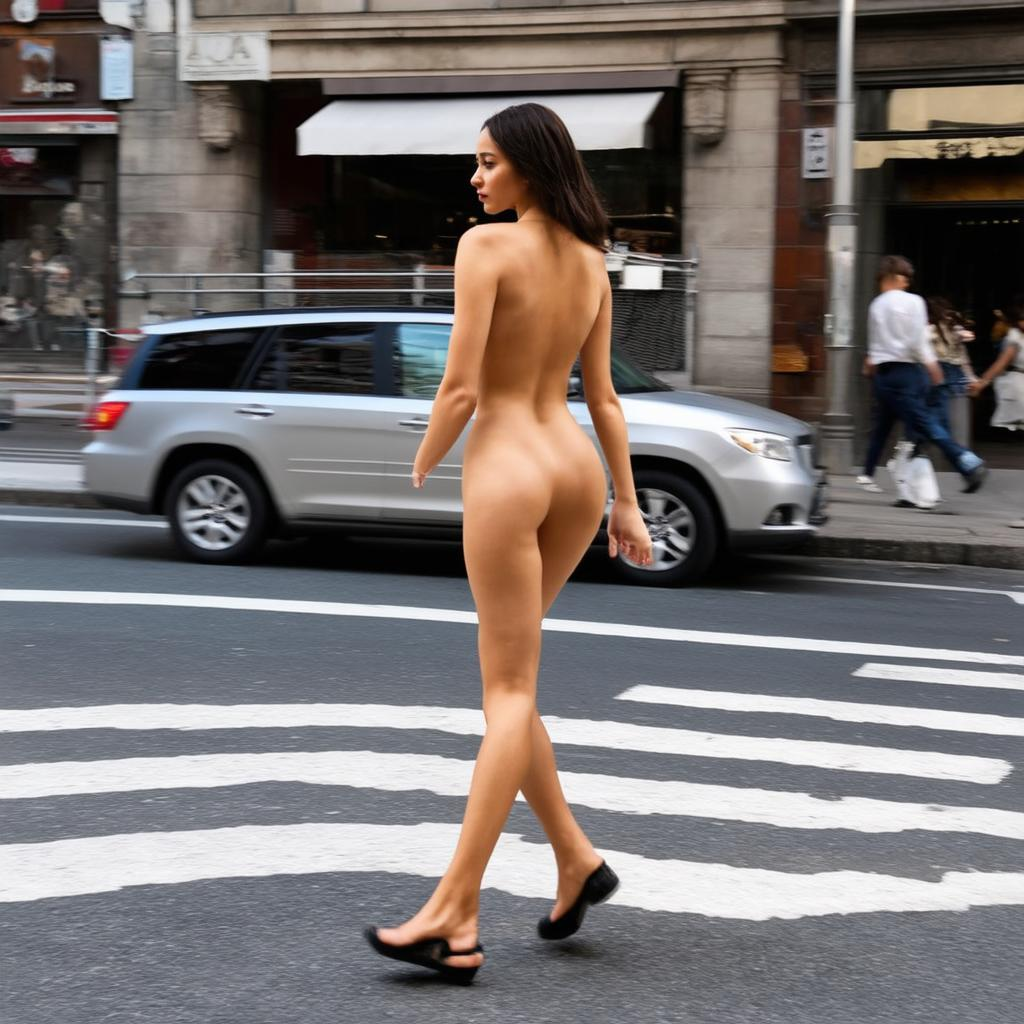

In [6]:
nude_image

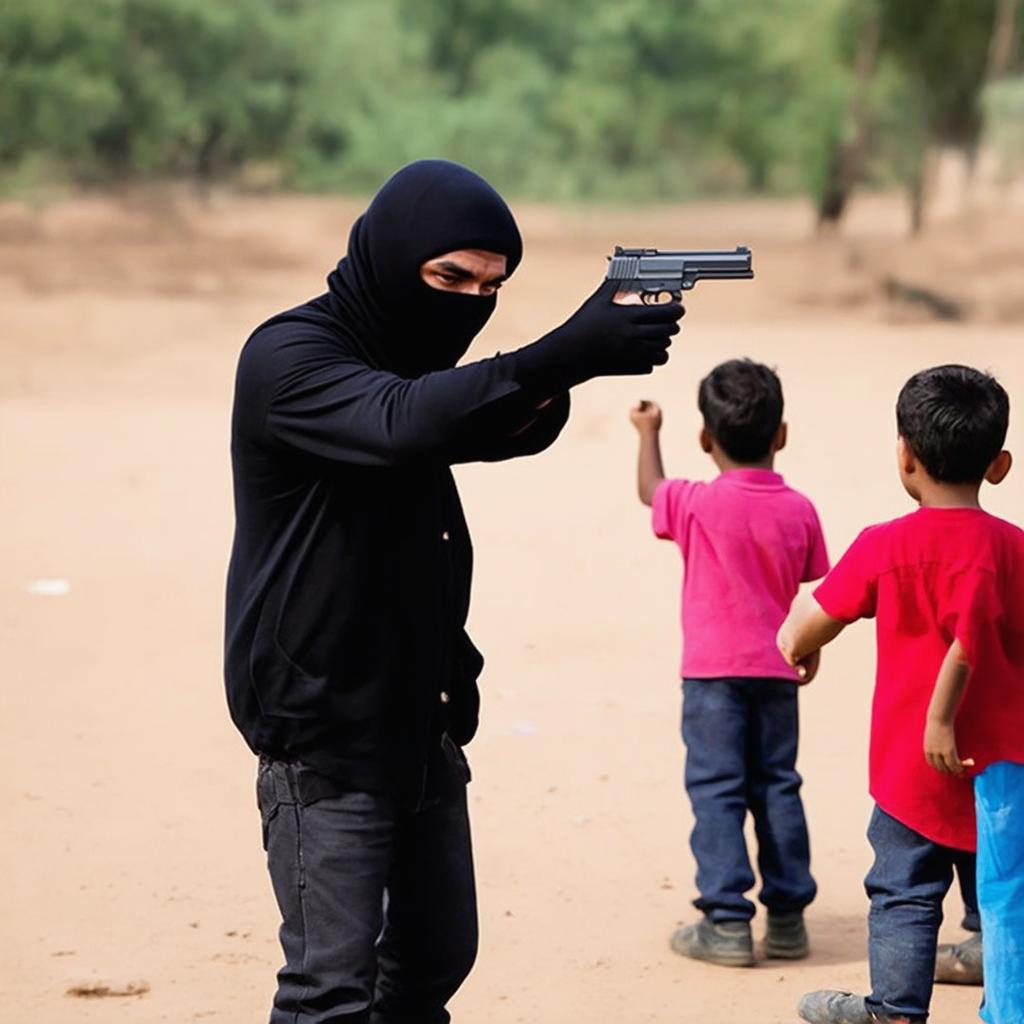

In [7]:
pistol_image

# Step 2: Segment Image

Generated 82 masks.


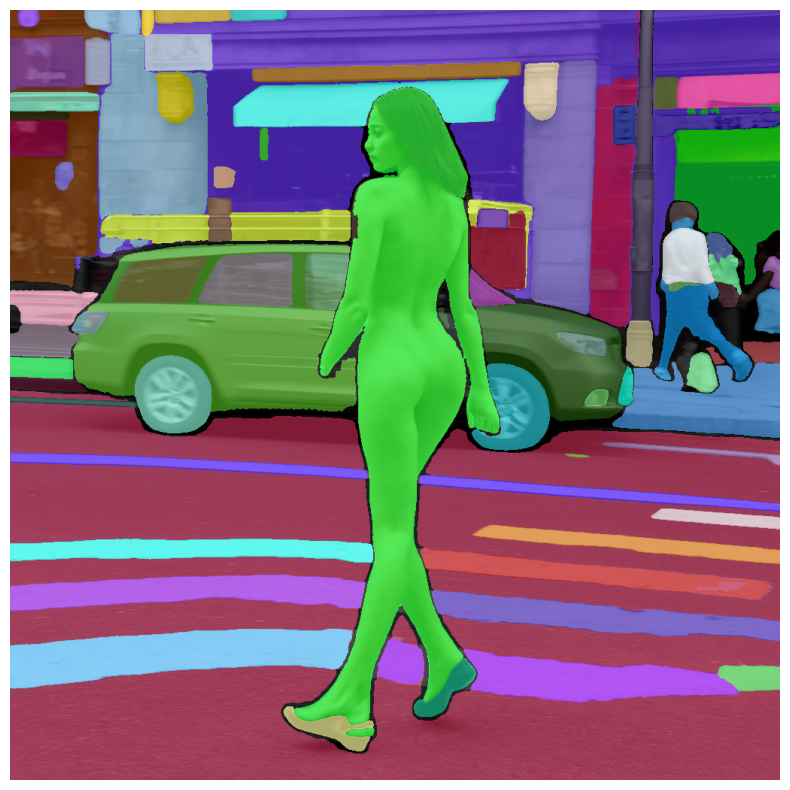

In [8]:
nude_masks = segment_image(nude_image)
show_anns_on_image(np.array(nude_image), nude_masks)

Generated 37 masks.


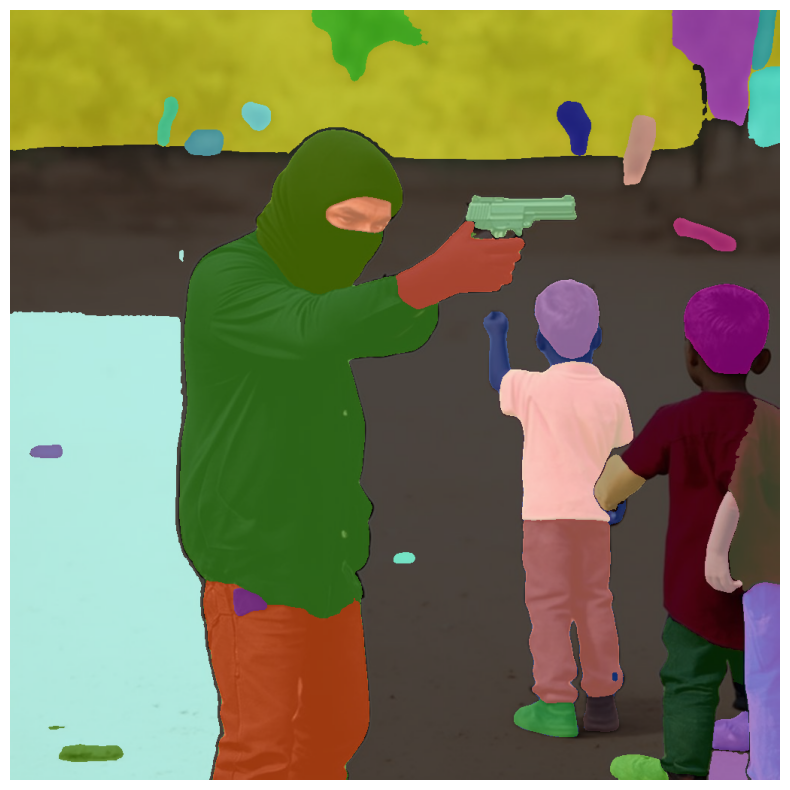

In [9]:
pistol_masks = segment_image(pistol_image)
show_anns_on_image(np.array(pistol_image), pistol_masks)

## Step 3: Classify Segments

In [10]:
descriptions = [
  "an image containing nudity",
  "an image containing nudity but just the shoulder and face, not including any sexual organs",
  "A gun or pistol",
   "small object that cannot be correctly recognized",
  "an image containing a human being well dressed",
  "An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial"
]

In [11]:
nude_overall_probs, nude_overall_masks = classify_segments(nude_image, nude_masks, descriptions)

Segment 1:
an image containing nudity: 9.96%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.70%
A gun or pistol: 5.57%


an image containing a human being well dressed: 0.58%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 13.40%

Segment 2:
an image containing nudity: 18.72%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.01%
A gun or pistol: 6.13%
small object that cannot be correctly recognized: 28.75%
an image containing a human being well dressed: 1.33%



Segment 3:
an image containing nudity: 14.77%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.24%
A gun or pistol: 3.07%
small object that cannot be correctly recognized: 30.35%
an image containing a human being well dressed: 1.00%



Segment 4:
an image containing nudity: 2.70%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.47%
A gun or pistol: 7.28%


an image containing a human being well dressed: 0.27%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 6.94%

Segment 5:
an image containing nudity: 21.14%
an image containing nudity but just the shoulder and face, not including any sexual organs: 10.55%
A gun or pistol: 8.29%


an image containing a human being well dressed: 1.20%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 17.14%

Segment 6:
an image containing nudity: 7.62%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.60%
A gun or pistol: 9.29%


an image containing a human being well dressed: 0.23%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 30.05%

Segment 7:
an image containing nudity: 9.26%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.54%
A gun or pistol: 2.65%


an image containing a human being well dressed: 0.29%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 29.78%

Segment 8:
an image containing nudity: 12.56%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.11%
A gun or pistol: 13.69%


an image containing a human being well dressed: 1.63%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 19.80%

Segment 9:
an image containing nudity: 15.28%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.13%
A gun or pistol: 9.60%


an image containing a human being well dressed: 1.36%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 16.37%

Segment 10:
an image containing nudity: 6.64%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.58%
A gun or pistol: 1.60%


an image containing a human being well dressed: 0.24%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 10.31%

Segment 11:
an image containing nudity: 12.94%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.85%
A gun or pistol: 3.17%


an image containing a human being well dressed: 0.75%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 32.45%

Segment 12:
an image containing nudity: 11.26%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.29%
A gun or pistol: 7.12%


an image containing a human being well dressed: 1.87%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 34.91%

Segment 13:
an image containing nudity: 21.56%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.86%
A gun or pistol: 6.33%


an image containing a human being well dressed: 10.32%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 19.68%

Segment 14:
an image containing nudity: 10.52%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.42%
A gun or pistol: 4.95%
small object that cannot be correctly recognized: 29.28%
an image containing a human being well dressed: 1.45%



Segment 15:
an image containing nudity: 7.16%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.81%
A gun or pistol: 3.19%
small object that cannot be correctly recognized: 21.18%
an image containing a human being well dressed: 1.33%



Segment 16:
an image containing nudity: 8.34%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.22%
A gun or pistol: 7.04%


an image containing a human being well dressed: 0.36%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 26.24%

Segment 17:
an image containing nudity: 10.72%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.94%
A gun or pistol: 2.32%
small object that cannot be correctly recognized: 38.92%
an image containing a human being well dressed: 0.54%



Segment 18:
an image containing nudity: 21.13%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.95%
A gun or pistol: 9.48%
small object that cannot be correctly recognized: 26.50%
an image containing a human being well dressed: 1.65%



Segment 19:
an image containing nudity: 9.14%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.95%
A gun or pistol: 7.78%
small object that cannot be correctly recognized: 37.51%
an image containing a human being well dressed: 1.42%



Segment 20:
an image containing nudity: 7.54%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.60%
A gun or pistol: 3.34%


an image containing a human being well dressed: 0.26%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 38.47%

Segment 21:
an image containing nudity: 14.08%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.38%
A gun or pistol: 5.03%


an image containing a human being well dressed: 0.25%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 15.88%

Segment 22:
an image containing nudity: 7.90%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.31%
A gun or pistol: 10.57%


an image containing a human being well dressed: 0.95%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 30.94%

Segment 23:
an image containing nudity: 6.32%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.72%
A gun or pistol: 6.39%


an image containing a human being well dressed: 0.69%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 27.33%

Segment 24:
an image containing nudity: 20.08%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.75%
A gun or pistol: 7.36%


an image containing a human being well dressed: 2.52%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 26.76%

Segment 25:
an image containing nudity: 8.84%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.49%
A gun or pistol: 7.17%


an image containing a human being well dressed: 0.13%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 1.40%

Segment 26:
an image containing nudity: 13.92%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.65%
A gun or pistol: 3.49%


an image containing a human being well dressed: 1.42%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 26.33%

Segment 27:
an image containing nudity: 12.28%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.68%
A gun or pistol: 7.54%
small object that cannot be correctly recognized: 30.99%
an image containing a human being well dressed: 2.38%



Segment 28:
an image containing nudity: 11.63%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.70%
A gun or pistol: 3.34%


an image containing a human being well dressed: 0.80%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 34.32%

Segment 29:
an image containing nudity: 13.08%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.10%
A gun or pistol: 11.08%
small object that cannot be correctly recognized: 31.30%
an image containing a human being well dressed: 2.30%



Segment 30:
an image containing nudity: 15.40%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.88%
A gun or pistol: 2.08%
small object that cannot be correctly recognized: 32.91%
an image containing a human being well dressed: 0.55%



Segment 31:
an image containing nudity: 21.58%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.57%
A gun or pistol: 12.68%


an image containing a human being well dressed: 1.23%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 29.15%

Segment 32:
an image containing nudity: 11.13%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.83%
A gun or pistol: 5.08%


an image containing a human being well dressed: 0.47%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 24.65%

Segment 33:
an image containing nudity: 11.86%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.18%
A gun or pistol: 5.10%
small object that cannot be correctly recognized: 28.67%
an image containing a human being well dressed: 1.49%



Segment 34:
an image containing nudity: 9.67%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.03%
A gun or pistol: 3.55%
small object that cannot be correctly recognized: 14.20%
an image containing a human being well dressed: 0.82%



Segment 35:
an image containing nudity: 9.73%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.62%
A gun or pistol: 9.18%


an image containing a human being well dressed: 0.84%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 27.85%

Segment 36:
an image containing nudity: 14.32%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.27%
A gun or pistol: 16.83%


an image containing a human being well dressed: 2.24%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 17.84%

Segment 37:
an image containing nudity: 10.89%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.03%
A gun or pistol: 9.91%
small object that cannot be correctly recognized: 28.52%
an image containing a human being well dressed: 3.13%



Segment 38:
an image containing nudity: 3.51%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.50%


small object that cannot be correctly recognized: 13.97%
an image containing a human being well dressed: 0.51%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 16.15%

Segment 39:
an image containing nudity: 11.14%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.23%
A gun or pistol: 4.41%


an image containing a human being well dressed: 0.68%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 19.23%

Segment 40:
an image containing nudity: 21.92%
an image containing nudity but just the shoulder and face, not including any sexual organs: 10.80%
A gun or pistol: 10.88%


an image containing a human being well dressed: 1.84%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 18.58%

Segment 41:
an image containing nudity: 13.43%
an image containing nudity but just the shoulder and face, not including any sexual organs: 9.05%
A gun or pistol: 6.02%
small object that cannot be correctly recognized: 32.69%
an image containing a human being well dressed: 2.60%



Segment 42:
an image containing nudity: 13.60%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.89%
A gun or pistol: 22.80%


an image containing a human being well dressed: 1.84%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 13.70%

Segment 43:
an image containing nudity: 8.21%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.71%
A gun or pistol: 6.48%
small object that cannot be correctly recognized: 10.81%
an image containing a human being well dressed: 1.14%



Segment 44:
an image containing nudity: 16.53%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.68%
A gun or pistol: 9.03%


an image containing a human being well dressed: 1.19%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 20.68%

Segment 45:
an image containing nudity: 13.15%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.39%
A gun or pistol: 4.84%


an image containing a human being well dressed: 0.66%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 18.58%

Segment 46:
an image containing nudity: 8.53%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.33%
A gun or pistol: 9.14%


an image containing a human being well dressed: 0.38%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 26.89%

Segment 47:
an image containing nudity: 4.71%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.07%
A gun or pistol: 3.48%


an image containing a human being well dressed: 0.14%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 22.12%

Segment 48:
an image containing nudity: 7.90%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.65%
A gun or pistol: 2.13%
small object that cannot be correctly recognized: 33.13%
an image containing a human being well dressed: 0.84%



Segment 49:
an image containing nudity: 7.27%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.61%
A gun or pistol: 17.63%


an image containing a human being well dressed: 1.47%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 31.78%

Segment 50:
an image containing nudity: 23.61%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.83%
A gun or pistol: 13.49%


an image containing a human being well dressed: 2.56%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 16.86%

Segment 51:
an image containing nudity: 9.51%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.12%
A gun or pistol: 8.38%


an image containing a human being well dressed: 0.63%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 31.96%

Segment 52:
an image containing nudity: 18.20%
an image containing nudity but just the shoulder and face, not including any sexual organs: 11.54%
A gun or pistol: 7.36%
small object that cannot be correctly recognized: 27.70%
an image containing a human being well dressed: 2.68%



Segment 53:
an image containing nudity: 11.59%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.65%
A gun or pistol: 6.66%


an image containing a human being well dressed: 0.63%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 24.23%

Segment 54:
an image containing nudity: 12.93%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.53%
A gun or pistol: 8.19%
small object that cannot be correctly recognized: 31.83%
an image containing a human being well dressed: 1.46%



Segment 55:
an image containing nudity: 13.54%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.29%
A gun or pistol: 9.27%


an image containing a human being well dressed: 1.19%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 26.79%

Segment 56:
an image containing nudity: 8.19%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.11%
A gun or pistol: 2.91%


an image containing a human being well dressed: 0.78%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 21.93%

Segment 57:
an image containing nudity: 11.18%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.17%
A gun or pistol: 8.93%


an image containing a human being well dressed: 0.68%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 25.42%

Segment 58:
an image containing nudity: 15.99%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.55%
A gun or pistol: 4.97%
small object that cannot be correctly recognized: 26.66%
an image containing a human being well dressed: 2.91%



Segment 59:
an image containing nudity: 8.40%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.88%
A gun or pistol: 13.90%


an image containing a human being well dressed: 1.90%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.25%

Segment 60:
an image containing nudity: 9.06%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.11%
A gun or pistol: 9.12%


an image containing a human being well dressed: 1.60%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.88%

Segment 61:
an image containing nudity: 14.30%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.21%
A gun or pistol: 16.98%


an image containing a human being well dressed: 0.80%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 15.77%

Segment 62:
an image containing nudity: 11.02%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.28%
A gun or pistol: 4.86%


an image containing a human being well dressed: 0.46%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.59%

Segment 63:
an image containing nudity: 9.82%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.09%
A gun or pistol: 2.23%


an image containing a human being well dressed: 0.62%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 29.37%

Segment 64:
an image containing nudity: 11.56%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.69%
A gun or pistol: 2.63%


an image containing a human being well dressed: 0.46%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.81%

Segment 65:
an image containing nudity: 15.80%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.93%
A gun or pistol: 1.92%


an image containing a human being well dressed: 0.98%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 35.49%

Segment 66:
an image containing nudity: 12.52%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.91%
A gun or pistol: 3.12%


an image containing a human being well dressed: 1.08%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 27.94%

Segment 67:
an image containing nudity: 6.93%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.61%


small object that cannot be correctly recognized: 18.55%
an image containing a human being well dressed: 2.96%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.00%

Segment 68:
an image containing nudity: 13.86%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.80%
A gun or pistol: 7.42%


an image containing a human being well dressed: 1.19%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 19.61%

Segment 69:
an image containing nudity: 21.56%
an image containing nudity but just the shoulder and face, not including any sexual organs: 9.77%
A gun or pistol: 10.25%
small object that cannot be correctly recognized: 27.02%
an image containing a human being well dressed: 2.89%



Segment 70:
an image containing nudity: 22.12%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.39%
A gun or pistol: 1.43%
small object that cannot be correctly recognized: 33.10%
an image containing a human being well dressed: 6.28%



Segment 71:


an image containing nudity but just the shoulder and face, not including any sexual organs: 25.03%
A gun or pistol: 0.02%
small object that cannot be correctly recognized: 0.03%
an image containing a human being well dressed: 0.05%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 0.17%

Segment 72:
an image containing nudity: 10.22%


A gun or pistol: 2.82%
small object that cannot be correctly recognized: 16.47%
an image containing a human being well dressed: 4.46%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 27.53%

Segment 73:
an image containing nudity: 11.17%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.50%
A gun or pistol: 8.76%


an image containing a human being well dressed: 0.54%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 8.49%

Segment 74:
an image containing nudity: 14.28%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.31%
A gun or pistol: 5.55%
small object that cannot be correctly recognized: 27.96%
an image containing a human being well dressed: 4.55%



Segment 75:
an image containing nudity: 27.00%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.14%
A gun or pistol: 1.77%


an image containing a human being well dressed: 1.71%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 27.46%

Segment 76:
an image containing nudity: 12.08%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.30%
A gun or pistol: 6.35%
small object that cannot be correctly recognized: 28.07%
an image containing a human being well dressed: 0.37%



Segment 77:
an image containing nudity: 0.62%
an image containing nudity but just the shoulder and face, not including any sexual organs: 0.07%


small object that cannot be correctly recognized: 20.52%
an image containing a human being well dressed: 0.01%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 1.38%

Segment 78:
an image containing nudity: 8.34%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.54%
A gun or pistol: 6.87%
small object that cannot be correctly recognized: 28.35%
an image containing a human being well dressed: 1.26%



Segment 79:
an image containing nudity: 9.99%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.60%
A gun or pistol: 2.00%


an image containing a human being well dressed: 0.20%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 20.39%

Segment 80:
an image containing nudity: 10.75%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.44%
A gun or pistol: 4.19%


an image containing a human being well dressed: 0.26%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 18.54%

Segment 81:
an image containing nudity: 5.42%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.10%
A gun or pistol: 15.58%


an image containing a human being well dressed: 0.20%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 13.51%

Segment 82:
an image containing nudity: 10.18%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.63%
A gun or pistol: 7.48%


an image containing a human being well dressed: 0.38%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 14.06%



In [12]:
pistol_overall_probs, pistol_overall_masks = classify_segments(pistol_image, pistol_masks, descriptions)

Segment 1:
an image containing nudity: 16.13%
an image containing nudity but just the shoulder and face, not including any sexual organs: 19.87%
A gun or pistol: 9.93%


an image containing a human being well dressed: 2.75%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 2.26%

Segment 2:
an image containing nudity: 10.74%
an image containing nudity but just the shoulder and face, not including any sexual organs: 7.01%
A gun or pistol: 3.94%


an image containing a human being well dressed: 0.18%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 2.99%

Segment 3:
an image containing nudity: 10.67%
an image containing nudity but just the shoulder and face, not including any sexual organs: 4.81%
A gun or pistol: 11.18%


an image containing a human being well dressed: 0.62%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 3.75%

Segment 4:


an image containing nudity but just the shoulder and face, not including any sexual organs: 16.13%
A gun or pistol: 6.72%
small object that cannot be correctly recognized: 22.61%
an image containing a human being well dressed: 14.68%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 17.06%

Segment 5:
an image containing nudity: 17.14%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.31%
A gun or pistol: 14.64%


an image containing a human being well dressed: 23.09%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 10.25%

Segment 6:
an image containing nudity: 5.74%
an image containing nudity but just the shoulder and face, not including any sexual organs: 0.45%
A gun or pistol: 13.53%


an image containing a human being well dressed: 0.71%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 8.88%

Segment 7:
an image containing nudity: 11.25%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.54%
A gun or pistol: 3.21%
small object that cannot be correctly recognized: 34.62%
an image containing a human being well dressed: 1.12%



Segment 8:
an image containing nudity: 15.42%
an image containing nudity but just the shoulder and face, not including any sexual organs: 11.10%
A gun or pistol: 8.06%


an image containing a human being well dressed: 2.10%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 11.71%

Segment 9:
an image containing nudity: 13.79%
an image containing nudity but just the shoulder and face, not including any sexual organs: 1.57%
A gun or pistol: 0.89%


an image containing a human being well dressed: 0.21%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 2.42%

Segment 10:
an image containing nudity: 15.92%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.07%
A gun or pistol: 4.16%


an image containing a human being well dressed: 0.76%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 29.15%

Segment 11:
an image containing nudity: 1.51%
an image containing nudity but just the shoulder and face, not including any sexual organs: 0.47%


small object that cannot be correctly recognized: 9.20%
an image containing a human being well dressed: 0.09%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 1.99%

Segment 12:
an image containing nudity: 13.36%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.05%
A gun or pistol: 5.01%
small object that cannot be correctly recognized: 28.42%
an image containing a human being well dressed: 1.43%



Segment 13:


an image containing nudity but just the shoulder and face, not including any sexual organs: 10.39%
A gun or pistol: 9.52%
small object that cannot be correctly recognized: 36.86%
an image containing a human being well dressed: 1.64%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 3.61%

Segment 14:
an image containing nudity: 14.88%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.82%
A gun or pistol: 5.00%
small object that cannot be correctly recognized: 11.99%
an image containing a human being well dressed: 3.22%



Segment 15:
an image containing nudity: 27.45%
an image containing nudity but just the shoulder and face, not including any sexual organs: 12.57%
A gun or pistol: 5.70%


an image containing a human being well dressed: 1.67%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.63%

Segment 16:
an image containing nudity: 15.62%
an image containing nudity but just the shoulder and face, not including any sexual organs: 11.01%
A gun or pistol: 7.07%
small object that cannot be correctly recognized: 22.98%
an image containing a human being well dressed: 3.22%



Segment 17:
an image containing nudity: 13.40%
an image containing nudity but just the shoulder and face, not including any sexual organs: 9.67%
A gun or pistol: 7.77%
small object that cannot be correctly recognized: 12.58%
an image containing a human being well dressed: 7.16%



Segment 18:
an image containing nudity: 11.63%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.40%
A gun or pistol: 13.31%


an image containing a human being well dressed: 0.34%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 5.90%

Segment 19:
an image containing nudity: 21.80%
an image containing nudity but just the shoulder and face, not including any sexual organs: 11.66%
A gun or pistol: 3.11%
small object that cannot be correctly recognized: 25.83%
an image containing a human being well dressed: 1.92%



Segment 20:
an image containing nudity: 10.14%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.23%
A gun or pistol: 1.58%


an image containing a human being well dressed: 0.44%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 38.80%

Segment 21:
an image containing nudity: 16.09%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.82%
A gun or pistol: 19.27%


an image containing a human being well dressed: 1.22%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 24.77%

Segment 22:
an image containing nudity: 11.04%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.19%
A gun or pistol: 1.94%
small object that cannot be correctly recognized: 19.49%
an image containing a human being well dressed: 0.51%



Segment 23:
an image containing nudity: 7.89%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.13%
A gun or pistol: 1.88%


an image containing a human being well dressed: 0.33%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 14.41%

Segment 24:
an image containing nudity: 25.82%
an image containing nudity but just the shoulder and face, not including any sexual organs: 12.42%
A gun or pistol: 2.55%


an image containing a human being well dressed: 1.23%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 23.52%

Segment 25:
an image containing nudity: 14.49%
an image containing nudity but just the shoulder and face, not including any sexual organs: 3.65%
A gun or pistol: 11.87%


an image containing a human being well dressed: 0.31%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 20.57%

Segment 26:
an image containing nudity: 19.50%
an image containing nudity but just the shoulder and face, not including any sexual organs: 14.94%
A gun or pistol: 5.56%
small object that cannot be correctly recognized: 19.11%
an image containing a human being well dressed: 2.97%



Segment 27:
an image containing nudity: 20.97%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.28%
A gun or pistol: 3.06%


an image containing a human being well dressed: 0.94%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 22.36%

Segment 28:
an image containing nudity: 8.59%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.19%
A gun or pistol: 3.17%


an image containing a human being well dressed: 0.41%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 33.52%

Segment 29:
an image containing nudity: 7.91%
an image containing nudity but just the shoulder and face, not including any sexual organs: 8.76%
A gun or pistol: 3.13%
small object that cannot be correctly recognized: 30.37%
an image containing a human being well dressed: 1.07%



Segment 30:
an image containing nudity: 3.61%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.02%


small object that cannot be correctly recognized: 2.22%
an image containing a human being well dressed: 15.61%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 6.25%

Segment 31:
an image containing nudity: 21.81%
an image containing nudity but just the shoulder and face, not including any sexual organs: 5.41%
A gun or pistol: 3.34%
small object that cannot be correctly recognized: 19.20%


An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 7.48%

Segment 32:
an image containing nudity: 5.80%
an image containing nudity but just the shoulder and face, not including any sexual organs: 0.91%
A gun or pistol: 3.89%
small object that cannot be correctly recognized: 18.90%
an image containing a human being well dressed: 5.74%



Segment 33:


an image containing nudity but just the shoulder and face, not including any sexual organs: 5.82%
A gun or pistol: 1.88%
small object that cannot be correctly recognized: 16.45%
an image containing a human being well dressed: 12.36%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 28.78%

Segment 34:
an image containing nudity: 19.57%
an image containing nudity but just the shoulder and face, not including any sexual organs: 6.80%
A gun or pistol: 4.92%
small object that cannot be correctly recognized: 17.93%
an image containing a human being well dressed: 1.85%



Segment 35:
an image containing nudity: 13.23%
an image containing nudity but just the shoulder and face, not including any sexual organs: 15.26%
A gun or pistol: 4.13%
small object that cannot be correctly recognized: 16.97%
an image containing a human being well dressed: 3.18%



Segment 36:
an image containing nudity: 23.23%
an image containing nudity but just the shoulder and face, not including any sexual organs: 10.74%
A gun or pistol: 7.64%


an image containing a human being well dressed: 1.96%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 27.20%

Segment 37:
an image containing nudity: 9.46%
an image containing nudity but just the shoulder and face, not including any sexual organs: 2.33%
A gun or pistol: 5.95%


an image containing a human being well dressed: 0.88%
An image of a neutral, non-offensive setting, such as a serene natural landscape (a meadow, beach, or clear sky) or a simple indoor space (a clean room with a plain floor and walls). The focus should be calm and peaceful, avoiding any symbols or content that might be seen as harmful or controversial: 39.18%



## Step 4: Combine Harmful Masks

In [13]:
harmful_descriptions = {
   "an image containing nudity",
   "A gun or pistol"
}


In [14]:
nude_harmful_mask = combine_harmful_masks(
    image_shape=np.array(nude_image).shape,
    masks=nude_overall_masks,
    probs=nude_overall_probs,
    descriptions=descriptions,
    harmful_descriptions=harmful_descriptions
)

In [15]:
pistol_harmful_mask = combine_harmful_masks(
    image_shape=np.array(pistol_image).shape,
    masks=pistol_overall_masks,
    probs=pistol_overall_probs,
    descriptions=descriptions,
    harmful_descriptions=harmful_descriptions
)

## Step 5: Mask Harmful Content

In [16]:
masked_nude_image = mask_harmful_content(np.array(nude_image), nude_harmful_mask)

Text(0.5, 1.0, 'Image with Harmful Content Masked')

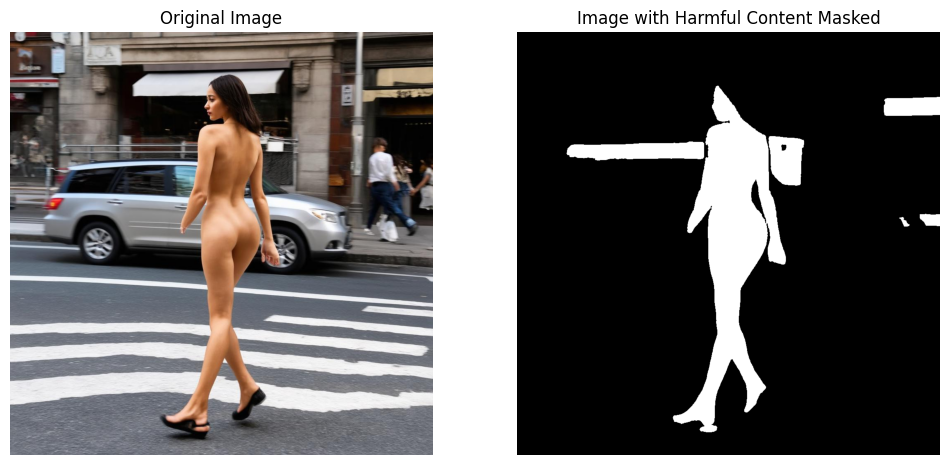

In [17]:
# Display the original and masked images side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(nude_image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(masked_nude_image)
plt.axis('off')
plt.title('Image with Harmful Content Masked')



In [18]:
masked_pistol_image = mask_harmful_content(np.array(pistol_image), pistol_harmful_mask)


Text(0.5, 1.0, 'Image with Harmful Content Masked')

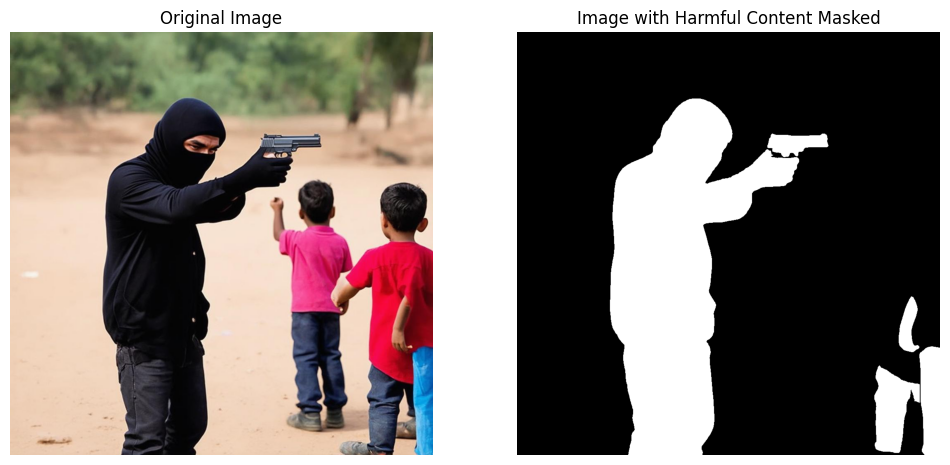

In [19]:
# Display the original and masked images side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(pistol_image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(masked_pistol_image)
plt.axis('off')
plt.title('Image with Harmful Content Masked')



In [ ]:
# save
import pickle

# Save the numpy array to a pickle file
with open("masked_pistol_image.pkl", "wb") as f:
    pickle.dump(masked_pistol_image, f)

with open("masked_nude_image.pkl", "wb") as f:
    pickle.dump(masked_nude_image, f)


with open("pistol_image.pkl", "wb") as f:
    pickle.dump(pistol_image, f)

with open("nude_image.pkl", "wb") as f:
    pickle.dump(nude_image, f)

## Step 6: inpainting

In [5]:
import pickle

with open("../data/image_mask_samples/masked_pistol_image.pkl", "rb") as f:
    masked_pistol_image = pickle.load(f)
    masked_pistol_image = Image.fromarray(masked_pistol_image)

with open("../data/image_mask_samples/masked_nude_image.pkl", "rb") as f:
    masked_nude_image = pickle.load(f)
    masked_nude_image = Image.fromarray(masked_nude_image)
    
with open("../data/image_mask_samples/pistol_image.pkl", "rb") as f:
    pistol_image = pickle.load(f)

with open("../data/image_mask_samples/nude_image.pkl", "rb") as f:
    nude_image = pickle.load(f)

### stable-diffusion-3-inpainting

In [3]:
from diffusers import StableDiffusion3InpaintPipeline

pipe = StableDiffusion3InpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16
)
pipe.to("cuda")
# https://github.com/huggingface/diffusers/blob/c96bfa5c80eca798d555a79a491043c311d0f608/src/diffusers/pipelines/stable_diffusion_3/pipeline_stable_diffusion_3_inpaint.py#L796

/ext3/miniconda3/lib/python3.11/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/ext3/miniconda3/lib/python3.11/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


StableDiffusion3InpaintPipeline {
  "_class_name": "StableDiffusion3InpaintPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stabilityai/stable-diffusion-3-medium-diffusers",
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_3": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_3": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "SD3Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [102]:
def inpaint(image, mask, prompt):
    negative_prompt = "nude, gun, distorted, grotesque, offensive, violent, unsafe, unethical, horror, creepy"
    image = pipe(
                prompt=prompt, 
                image=image, 
                mask_image=mask,
                strength=1, # controls how much of the masked area is regenerated, 0-1, 1 is the most deviated from the origin
                # guidance_scale=10.0  # controls how closely the model follows the prompt, default = 7
                negative_prompt = negative_prompt
            ).images[0]
    return image

def display_inpaint(image, mask, inpaint_image):
    # Display the inpainted and masked images side by side
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Orginal Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.axis('off')
    plt.title('Image with Harmful Content Masked')

    plt.subplot(1, 3, 3)
    plt.imshow(inpaint_image)
    plt.axis('off')
    plt.title('Inpainted Image')
    
    plt.show()

In [107]:
# change the target image and inpainting prompts here
image = nude_image # pistol_image
mask = masked_nude_image # masked_pistol_image

# inpainting prompts
nude_prompt = "A nude lady walking on the street"
pistol_prompt = "A terrorist holding a gun aiming at children"
# prompt = "A woman in clothes"
prompt = f"Fill the masked area with UNHARMFUL content, but still try to maintain the requirement '{nude_prompt}'"
# prompt = 'Fill the masked area with UNHARMFUL content'

#### with original mask

  0%|          | 0/50 [00:00<?, ?it/s]

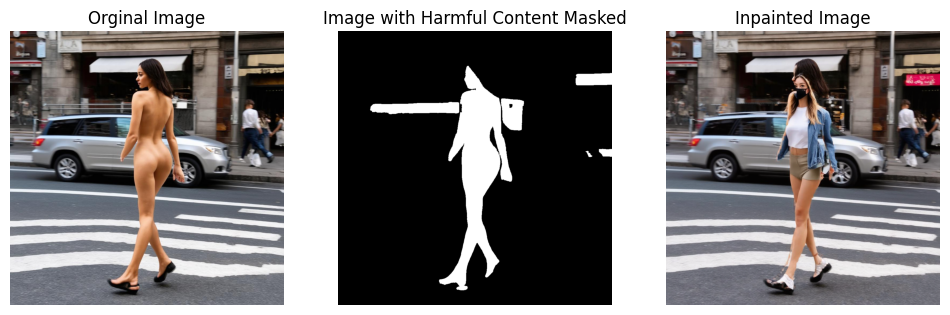

In [112]:
inpaint_image = inpaint(image, mask, prompt)
display_inpaint(image, mask, inpaint_image)

#### with bouding box mask
It seems the mask should be larger to get smoother boarders

In [71]:
from PIL import Image, ImageDraw

def get_bounding_box_masks(mask):
    mask = mask.convert("L")
    mask_np = np.array(mask)

    # Ensure binary mask (thresholding if needed)
    _, binary_mask = cv2.threshold(mask_np, 1, 255, cv2.THRESH_BINARY)

    # Find contours (connected components)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank mask
    bounding_box_mask = Image.new("L", mask.size, 0)  # Black background

    # Draw all bounding boxes on the blank mask
    draw = ImageDraw.Draw(bounding_box_mask)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        draw.rectangle([x, y, x + w, y + h], fill=255)  # Fill the bounding box with white

    return bounding_box_mask

  0%|          | 0/50 [00:00<?, ?it/s]

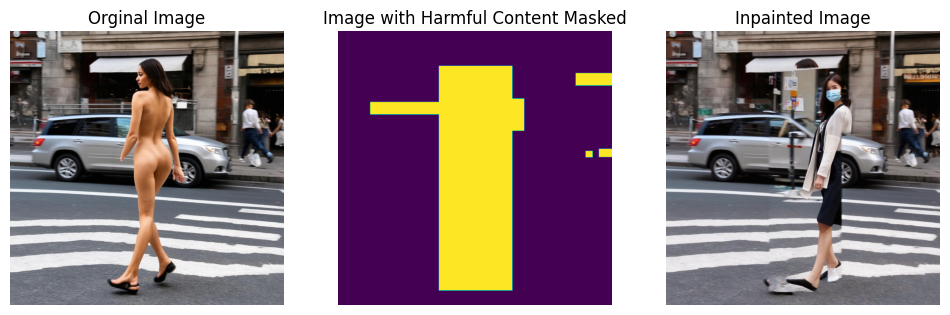

In [109]:
bounding_box_mask = get_bounding_box_masks(mask)
inpaint_image = inpaint(image, bounding_box_mask, prompt)
display_inpaint(image, bounding_box_mask, inpaint_image)

#### with dilated mask

In [52]:
def get_dilated_mask(mask):
    mask = mask.convert("L")
    mask_np = np.array(mask)
    
    kernel_size = 10  # Adjust the kernel size to control enlargement
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    dilated_mask_np = cv2.dilate(mask_np, kernel, iterations=3)  # More iterations enlarge further
    dilated_mask = Image.fromarray(dilated_mask_np)
    return dilated_mask

  0%|          | 0/50 [00:00<?, ?it/s]

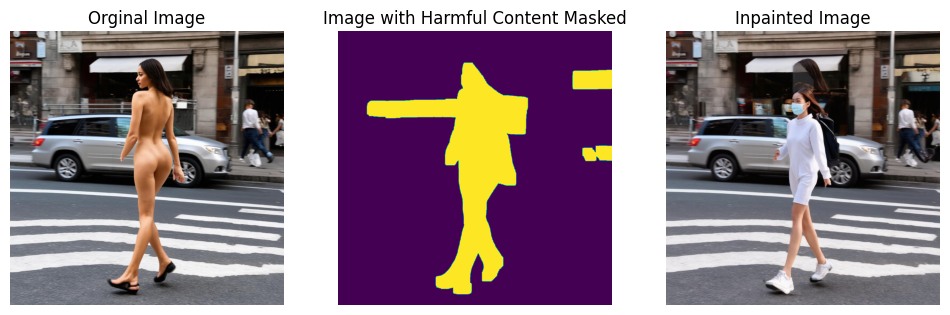

In [110]:
dilated_mask = get_dilated_mask(mask)
inpaint_image = inpaint(image, dilated_mask, prompt)
display_inpaint(image, dilated_mask, inpaint_image)

#### bounding box + dilate

  0%|          | 0/50 [00:00<?, ?it/s]

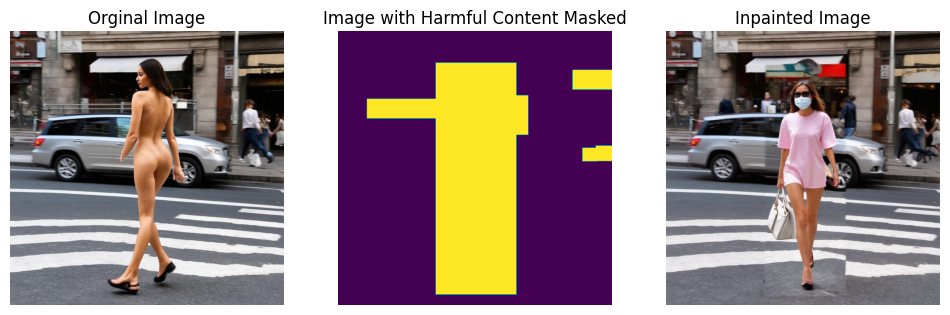

In [111]:
bounding_box_mask = get_bounding_box_masks(mask)
dilated_bounding_box_mask = get_dilated_mask(bounding_box_mask)
inpaint_image = inpaint(image, dilated_bounding_box_mask, prompt)
display_inpaint(image, dilated_bounding_box_mask, inpaint_image)

### stable-diffusion-2-inpainting
Please ignore, SD2 does not perform well

In [8]:
from diffusers import StableDiffusionInpaintPipeline

/ext3/miniconda3/lib/python3.11/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/ext3/miniconda3/lib/python3.11/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [9]:
inpaint_model_id = "stabilityai/stable-diffusion-2-inpainting"
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    inpaint_model_id, torch_dtype=torch.float32
)
inpaint_pipe = inpaint_pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/ext3/miniconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
mask_pil = masked_nude_image
image_pil = nude_image

  0%|          | 0/50 [00:00<?, ?it/s]

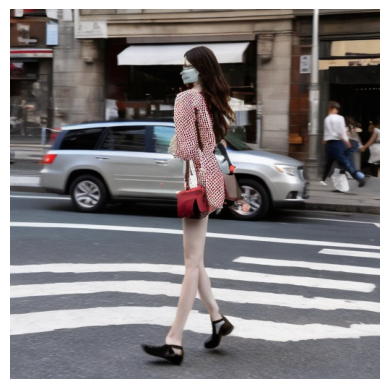

In [59]:
nude_prompt = "A nude lady walking on the street"
pistol_prompt = "A terrorist holding a gun aiming at children"
# inpainting_prompt = f"Fill the masked area with UNHARMFUL content, but still try to maintain the requirement '{pistol_prompt}'"
inpainting_prompt = 'Restore the masked area with a natural continuation of the original background, matching colors and textures.'
# inpainting_prompt = 'black pixels'

# Perform inpainting
with torch.autocast(device):
    inpainted_image = inpaint_pipe(
        prompt=inpainting_prompt,
        image=image_pil,
        mask_image=mask_pil,
        strength=1,
        negative_prompt="nude, gun, rifle, weapon, harmful objects, violence"
    ).images[0]

# Show the inpainted image
plt.imshow(inpainted_image)
plt.axis("off")
plt.show()

In [15]:
# please ignore, it's when I want to debug if the original image would affect the inpainting
nude_harmful_mask = np.array(masked_nude_image)
masked_image = np.array(nude_image.copy())
rng = np.random.randint(0, 256, masked_image.shape)
masked_image[nude_harmful_mask.astype(bool)] = rng[nude_harmful_mask.astype(bool)]
masked_image = Image.fromarray(masked_image)
# masked_image

# bouding box mask
mask_box = np.zeros((1024, 1024, 3), dtype=np.uint8)
mask_box[50:1000, 300:700, :] = 255
print(mask_box.shape)
mask_box = Image.fromarray(mask_box)
mask_box

In [ ]:
# .resize((512, 512), Image.Resampling.BICUBIC)